# Content based recommendation

Content based recommendation egnines compare items and find items similar to a query item. In this exercise, we will learn to measure the similarity of textual documents and build  a recommender for news articles.

In [1]:
from __future__ import print_function
import requests
import time
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

Define some helper functions we are going to use later.

In [2]:
def row_as_array(M, i):
  """Get the i:th row of a sparse matrix M and return it as a 1-D numpy array"""
  return np.squeeze(np.asarray(tf[i, :].todense()))

def row_as_series(M, i, vectorizer):
  return pd.Series(row_as_array(M, i), index=vectorizer.get_feature_names())

## News article dataset

Let's load a set of Reuters news articles. We'll need to clean the data a bit and extract the actual text of the articles to a variable called `documents`.

In [3]:
dataset = requests.get('http://ana.cachopo.org/datasets-for-single-label-text-categorization/r52-train-all-terms.txt?attredirects=0').content

In [4]:
documents = []
labels = []
for line in dataset.decode('UTF-8').split('\n'):
  # the part before the tab is a document class, which we ignore here
  fields = line.strip().split('\t', 1)
  if len(fields) == 2:
    labels.append(fields[0])
    documents.append(fields[1])

labels = np.array(labels)
documents = pd.Series(documents)

print('Loaded {} documents'.format(len(documents)))

Loaded 6532 documents


The news articles have been grouped to these categories (each article belong to one of the categories):

In [5]:
np.unique(labels)

array(['acq', 'alum', 'bop', 'carcass', 'cocoa', 'coffee', 'copper',
       'cotton', 'cpi', 'cpu', 'crude', 'dlr', 'earn', 'fuel', 'gas',
       'gnp', 'gold', 'grain', 'heat', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'lead', 'lei',
       'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply',
       'nat-gas', 'nickel', 'orange', 'pet-chem', 'platinum', 'potato',
       'reserves', 'retail', 'rubber', 'ship', 'strategic-metal', 'sugar',
       'tea', 'tin', 'trade', 'veg-oil', 'wpi', 'zinc'], 
      dtype='<U15')

Let's print the first news articles to see how they look. Notice that punctuation and upper cases have already been removed in the data source. 

In [6]:
print(documents[0])

bahia cocoa review showers continued throughout the week in the bahia cocoa zone alleviating the drought since early january and improving prospects for the coming temporao although normal humidity levels have not been restored comissaria smith said in its weekly review the dry period means the temporao will be late this year arrivals for the week ended february were bags of kilos making a cumulative total for the season of mln against at the same stage last year again it seems that cocoa delivered earlier on consignment was included in the arrivals figures comissaria smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end with total bahia crop estimates around mln bags and sales standing at almost mln there are a few hundred thousand bags still in the hands of farmers middlemen exporters and processors there are doubts as to how much of this cocoa would be fit for export as shippers are now experiencing dificul

## Preprocessing text documents

Most of the machine learning methods deal with number, not text. Therefore, text is commonly converted into numerical vectors for processing. A simple baseline method is to just count how many times each word appears in a document and collect the counts (called, the term frequencies) into a vector. The scikit-learn library provides a tool for performing the conversion.

* The `ngram_range` parameter indicates that we want to have not just the individual words as tokens, but also sequences of 2 and 3 consequtive words.
* The `min_df` parameter filters out tokens which appear less frequently than in 0.5% of the documents.
* The `stop_words` parameter filters out common English words.

See the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for more information.

In [7]:
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=0.005, stop_words='english')
vectorizer.fit(documents)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.005,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

The `fit` method collects the tokens that appear in the documents and match the `ngram_range`, `min_df`, `stop_word` parameters.

Let's see what kind of tokens it found.

In [8]:
print('Number of tokens: {}'.format(len(vectorizer.get_feature_names())))

print()
print('First 10 tokens:')
vectorizer.get_feature_names()[:10]

Number of tokens: 1463

First 10 tokens:


['ab',
 'ability',
 'able',
 'abroad',
 'accept',
 'accepted',
 'access',
 'accord',
 'according',
 'account']

The main functionality of the vectorizer is that we can convert text documents into vectors.

In [9]:
tf = vectorizer.transform(documents)

`tf` is a matrix, where each row is a count vector for one document.

Let's define a helper function for inspecting the rows and inspect the first document vector.

In [10]:
print("The dimension of the tf matrix are {}".format(tf.shape))

The dimension of the tf matrix are (6532, 1463)


In [11]:
x = row_as_series(tf, 0, vectorizer)
x

ab              0
ability         0
able            0
abroad          0
accept          0
accepted        0
access          0
accord          0
according       0
account         0
accounted       0
accounting      0
accounts        0
achieve         0
achieved        0
acquire         0
acquired        0
acquires        0
acquiring       0
acquisition     0
acquisitions    0
act             0
action          0
actions         0
active          0
activities      0
activity        0
actual          0
add             0
added           0
               ..
weekly          1
weeks           1
went            1
west            0
western         0
white           0
wholesale       0
wholly          0
wide            0
william         0
willing         0
won             0
work            0
workers         0
workforce       0
working         0
world           0
worldwide       0
worth           0
write           0
writedown       0
year            2
years           0
yen             0
yesterday 

Most of the counts are zeros because one document contains only a subset of all words in the vocabulary.

To show that it's not all zeroes, let's take a subset that includes some non-zero values:

In [12]:
x['cocoa':'commission']

cocoa          7
coffee         0
colombia       0
combination    0
combined       0
come           1
coming         1
comment        0
commenting     0
commerce       0
commercial     0
commission     1
dtype: int64

The length of the news articles varies from a couple of words to over 300 words as can be seen below.

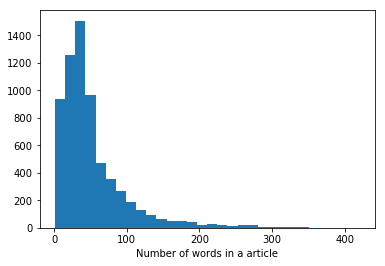

In [13]:
plt.hist(tf.sum(axis=1), bins=30)
plt.xlabel('Number of words in a article')
plt.show()

We don't want to consider two documents similar just because they have similar number of words. Therefore, we normalize the term frequency matrix.

In [14]:
Xnormalized = normalize(tf.todense(), norm='l2')

/home/aaja/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


## Dimensionality reduction

Human can't easily understand the tf matrix that has over 1000 dimensions. If we want to visualize the data, we need to reduce it to two dimensions. This will obviously lose some (or actually quite a lot of) information in the data, but PCA will keep the most important dimensions. 

In [15]:
dimreduction = PCA(n_components=2)
Xreduced = dimreduction.fit_transform(Xnormalized)

In [16]:
print("The dimensionality of the original tf matrix: {}".format(tf.shape))
print("The dimensionality after PCA: {}".format(Xreduced.shape))

The dimensionality of the original tf matrix: (6532, 1463)
The dimensionality after PCA: (6532, 2)


Let's plot the data after the dimensionality reduction.

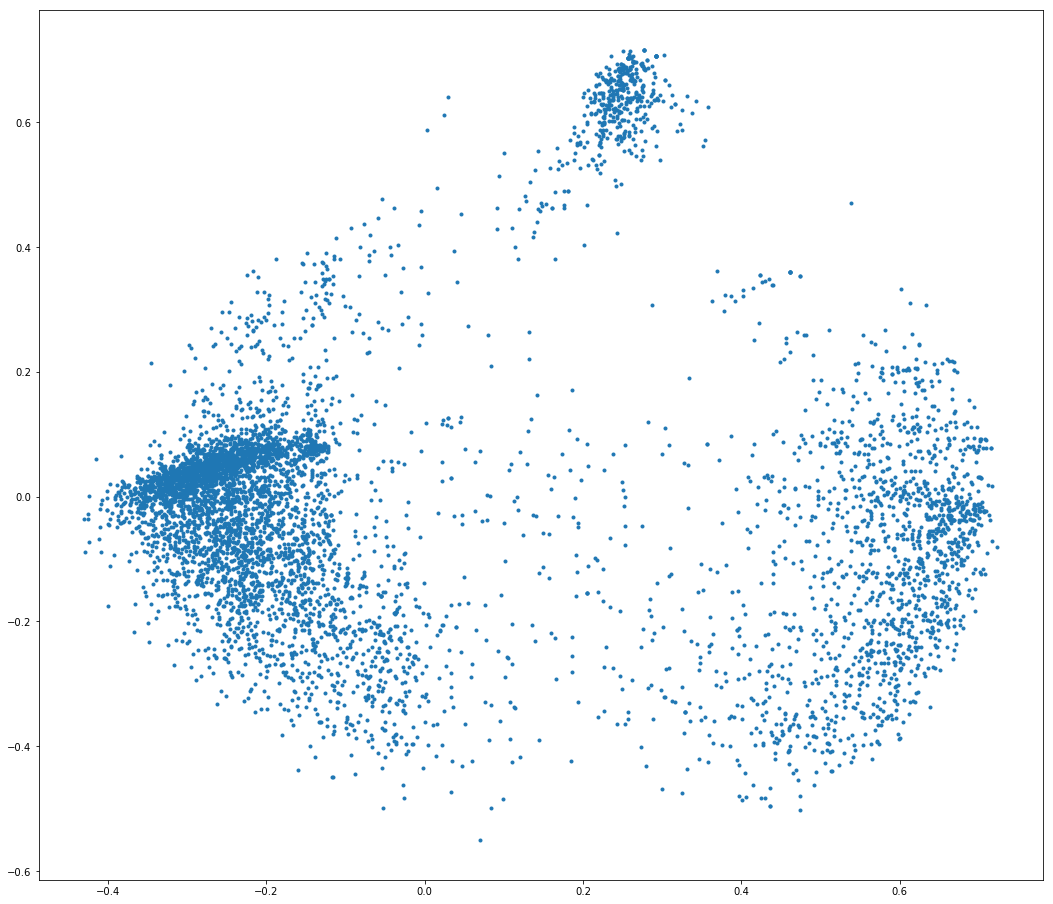

In [17]:
plt.figure(figsize=(18, 16))
plt.plot(Xreduced[:, 0], Xreduced[:, 1], '.')
plt.show()

There seems to be some interesting structure in the data, at least three separated clusters.

To better understand what kind of articles belong to the clusters, we can overlay the beginning of a few random documents on the image.

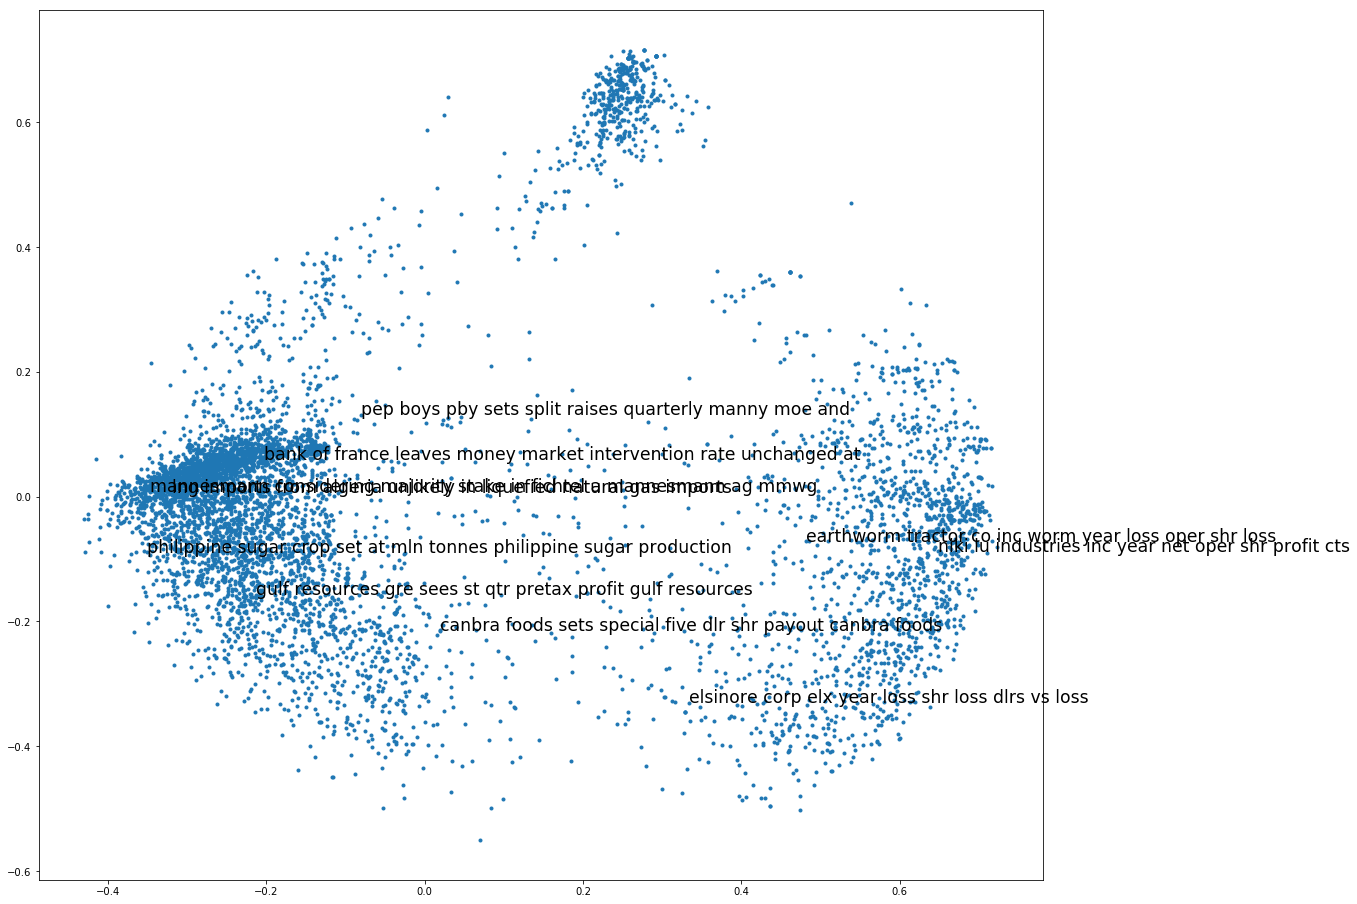

In [18]:
plt.figure(figsize=(18, 16))
plt.plot(Xreduced[:, 0], Xreduced[:, 1], '.')

indexes = random.sample(range(tf.shape[0]), 10)
for i in indexes:
    label = ' '.join(documents[i].split(' ')[:10])
    plt.text(Xreduced[i, 0], Xreduced[i, 1], label, size='xx-large')

plt.show()

## Clustering

In [19]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(Xreduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The clustering algorithm assigned a cluster index to each sample. Let's see the first few cluster indexes:

In [20]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

We can visualize the clustering result by drawing each data point with the color corresponding the its cluster.

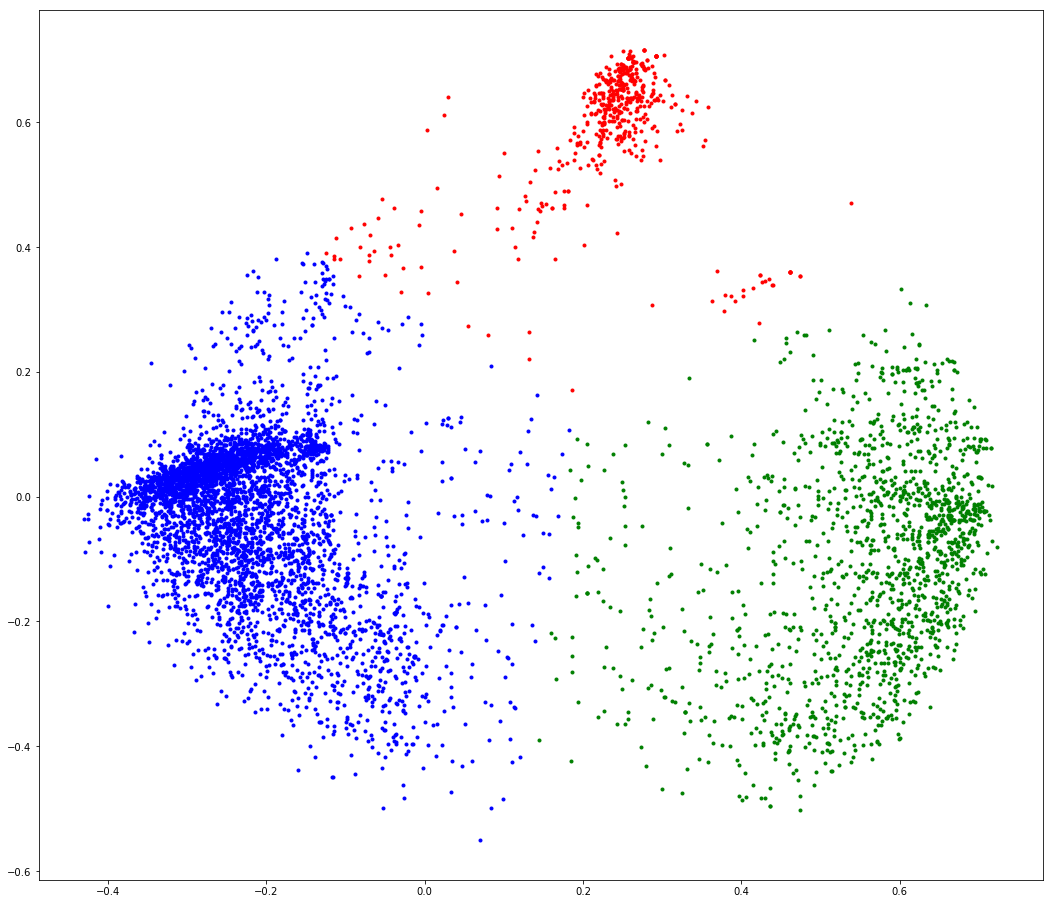

In [21]:
available_colors = 'bgrcmyk'
colors = [available_colors[i % len(available_colors)] for i in kmeans.labels_]

plt.figure(figsize=(18, 16))
for i in range(Xreduced.shape[0]):
    plt.plot(Xreduced[i, 0], Xreduced[i, 1], '.', color=colors[i])
plt.show()

Clustering the two dimensional data is a toy example because you can already see the structure by looking at the visualization.

In reality, clustering is applied to high dimensional data, like the new article data before the dimensionality reduction.

In [22]:
kmeans2 = KMeans(n_clusters=6)
kmeans2.fit(Xnormalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
for cl in range(kmeans2.n_clusters):
    indexes = random.sample(np.where(kmeans2.labels_ == cl)[0].tolist(), 5)

    print("Random documents from cluster {}".format(cl))
    print('-'*40)
    
    for i in indexes:
        print(documents[i])
        
    print()

Random documents from cluster 0
----------------------------------------
mikron instrument co mikr st qtr jan shr three cts vs four cts net vs revs vs reuter
tab products co tbp rd qtr feb net shr cts vs cts net vs revs mln vs mln nine mths shr cts vs cts net vs revs mln vs mln reuter
consolidated stores corp cns th qtr jan net shr cts vs cts net vs sales mln vs mln avg shrs mln vs mln year shr cts vs cts net mln vs mln sales mln vs mln avg shrs mln vs mln note prior year net includes dlr tax credit share adjusted for two for one stock split in june reuter
fhlmc frepr th qtr net net mln vs mln year shr preferred dlrs vs dlrs shr common dlrs vs dlrs net mln vs mln note federal home loan mortgage corp fhlmc had preferred shares outstanding in vs in owned by about member institutions of the federal home loan banks fhlmc also has shares of common owned by the home loan banks reuter
autrex inc st qtr january net shr one cts vs two cts net vs revs vs reuter

Random documents from cluster 1
-

## Exercise

Vary the number of clusters (`n_clusters`) and both analyses (the clustering of the dimensionality reduced data and the clustering of the original data). How large or small number of clusters still leads to sensible clusterings?

## Exercise

The CountVectorizer tends to overweight very common words. A better way is to re-weight words that appear in many documents by multiplying the raw term frequencies (TF) with (some function of) the inverse of in how many documnets a term occurs (inverse document frequencies, IDF). The resulting vectors are called TF-IDF vectors. Scikit-learn provides [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) for this task. It is almost a drop-in replacement for the CountVectorizer that was used above.

Repeat the above analysis with TfidfVectorizer.